# Counterfactual with Reinforcement Learning (CFRL) on MNIST

This method is described in [Model-agnostic and Scalable Counterfactual Explanations via Reinforcement Learning](https://arxiv.org/abs/2106.02597) and can generate counterfactual instances for any black-box model. The usual optimization procedure is transformed into a learnable process allowing to generate batches of counterfactual instances in a single forward pass even for high dimensional data. The training pipeline is model-agnostic and relies only on prediction feedback by querying the black-box model. Furthermore, the method allows target and feature conditioning. 

**We exemplify the use case for the TensorFlow backend. This means that all models: the autoencoder, the actor, the critic, and the black-box classifier are TensorFlow models. Our implementation supports PyTorch backend as well.**

CFRL uses [Deep Deterministic Policy Gradient (DDPG)](https://arxiv.org/abs/1509.02971) by interleaving a state-action function approximator called critic, with a learning an approximator called actor to predict the optimal action. The method assumes that the critic is differentiable with respect to the action argument, thus allowing to optimize the actor's parameters efficiently through gradient-based methods.

The DDPG algorithm requires two separate networks, an actor $\mu$ and a critic $Q$. Given the encoded representation of the input instance $z = enc(x)$, the model prediction $y_M$, the target prediction
$y_T$ and the conditioning vector $c$, the actor outputs the counterfactual’s latent representation $z_{CF} = \mu(z, y_M, y_T, c)$. The decoder then projects the embedding $z_{CF}$ back to the original input space,
followed by optional post-processing.

The training step consists of simultaneously optimizing the actor and critic networks. The critic regresses on the reward $R$ determined by the model prediction, while the actor maximizes the critic’s output for the given instance through $L_{max}$. The actor also minimizes two objectives to encourage the generation of sparse, in-distribution counterfactuals. The sparsity loss $L_{sparsity}$ operates on the decoded counterfactual $x_{CF}$ and combines the $L_1$ loss over the standardized numerical features and the $L_0$ loss over the categorical ones. The consistency loss $L_{consist}$ aims to encode the counterfactual $x_{CF}$ back to the same latent representation where it was decoded from and helps to produce in-distribution counterfactual instances.Formally, the actor's loss can be written as:
$L_{actor} = L_{max} + \lambda_{1}L_{sparsity} + \lambda_{2}L_{consistency}$

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict

import tensorflow as tf
import tensorflow.keras as keras

from alibi.explainers import CounterfactualRLBase
from alibi.models.tensorflow.autoencoder import AE
from alibi.models.tensorflow.actor_critic import Actor, Critic
from alibi.models.tensorflow.cfrl_models import MNISTEncoder, MNISTDecoder, MNISTClassifier
from alibi.explainers.cfrl_base import ExperienceCallback, TrainingCallback

/home/robert/anaconda3/envs/dl/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


## Load MNIST dataset

In [2]:
# Define constants.
BATCH_SIZE = 64
BUFFER_SIZE = 1024

# Load MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

# Expand dimensions and normalize.
X_train = np.expand_dims(X_train, axis=-1).astype(np.float32) / 255.
X_test = np.expand_dims(X_test, axis=-1).astype(np.float32) / 255.

# Define trainset.
trainset_classifier = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
trainset_classifier = trainset_classifier.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

# Define testset.
testset_classifier = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
testset_classifier = testset_classifier.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

### Define and train CNN classifier

In [3]:
# Number of classes.
NUM_CLASSES = 10
EPOCHS = 5

# Define classifier path and create dir if it doesn't exist.
classifier_path = os.path.join("tensorflow", "MNIST_classifier")
if not os.path.exists(classifier_path):
    os.makedirs(classifier_path)

# Construct classifier. This is the classifier used in the paper experiments.
classifier = MNISTClassifier(output_dim=NUM_CLASSES)

# Define optimizer and loss function
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Complile the model.
classifier.compile(optimizer=optimizer, 
                   loss=loss,
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


if len(os.listdir(classifier_path)) == 0:
    # Fit and save the classifier.
    classifier.fit(trainset_classifier, epochs=EPOCHS)
    classifier.save(classifier_path)
else:
    # Load the classifier if already fitted.
    classifier = keras.models.load_model(classifier_path)

In [4]:
# Evaluate the classifier
loss, accuracy = classifier.evaluate(testset_classifier)

157/157 [==============================] - 2s 6ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9861


### Define the predictor (black-box)

Now that we've trained the CNN classifier, we can define the black-box model. Note that the output of the black-box is a distribution which can be either a soft-label distribution (probabilities/logits for each class) or a hard-label distribution (one-hot encoding). Internally, CFRL takes the `argmax`. Moreover the output **DOES NOT HAVE TO BE DIFFERENTIABLE**.

In [5]:
# Define predictor function (black-box) used to train the CFRL
def predictor(X: np.ndarray):
    Y = classifier(X).numpy()
    return Y

### Define and train autoencoder

Instead of directly modeling the perturbation vector in the potentially high-dimensional input space, we first train an autoencoder. The weights of the encoder are frozen and the actor applies the
counterfactual perturbations in the latent space of the encoder. The pre-trained decoder maps the counterfactual embedding back to the input feature space. 

The autoencoder follows a standard design. The model is composed from two submodules, the encoder and the decoder. The forward pass consists of passing the input to the encoder, obtain the input embedding and pass the embedding through the decoder.

```python
class AE(keras.Model):
    def __init__(self, encoder: keras.Model, decoder: keras.Model, **kwargs) -> None:
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x: tf.Tensor, **kwargs):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
```

In [6]:
# Define autoencoder trainset.
trainset_ae = tf.data.Dataset.from_tensor_slices(X_train)
trainset_ae = trainset_ae.map(lambda x: (x, x))
trainset_ae = trainset_ae.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

# Define autoencode testset.
testset_ae = tf.data.Dataset.from_tensor_slices(X_test)
testset_ae = testset_ae.map(lambda x: (x, x))
testset_ae = testset_ae.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
# Define autoencoder path and create dir if it doesn't exist.
ae_path = os.path.join("tensorflow", "MNIST_autoencoder")
if not os.path.exists(ae_path):
    os.makedirs(ae_path)

# Define latent dimension.
LATENT_DIM = 64
EPOCHS = 50
    
# Define autoencoder.
ae = AE(encoder=MNISTEncoder(latent_dim=LATENT_DIM),
        decoder=MNISTDecoder())

# Define optimizer and loss function.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.BinaryCrossentropy(from_logits=False)

# Compile autoencoder.
ae.compile(optimizer=optimizer, loss=loss)

if len(os.listdir(ae_path)) == 0:
    # Fit and save autoencoder.
    ae.fit(trainset_ae, epochs=EPOCHS)
    ae.save(ae_path)
else:
    # Load the model.
    ae = keras.models.load_model(ae_path)

### Test the autoencoder

In [8]:
# Define number of samples to be displayed
NUM_SAMPLES = 5

# Get some random samples from test
np.random.seed(0)
indices = np.random.choice(X_test.shape[0], NUM_SAMPLES)
inputs = [X_test[i].reshape(1, 28, 28, 1) for i in indices]
inputs = np.concatenate(inputs, axis=0)

# Pass samples through the autoencoder
inputs_hat = ae(inputs).numpy()

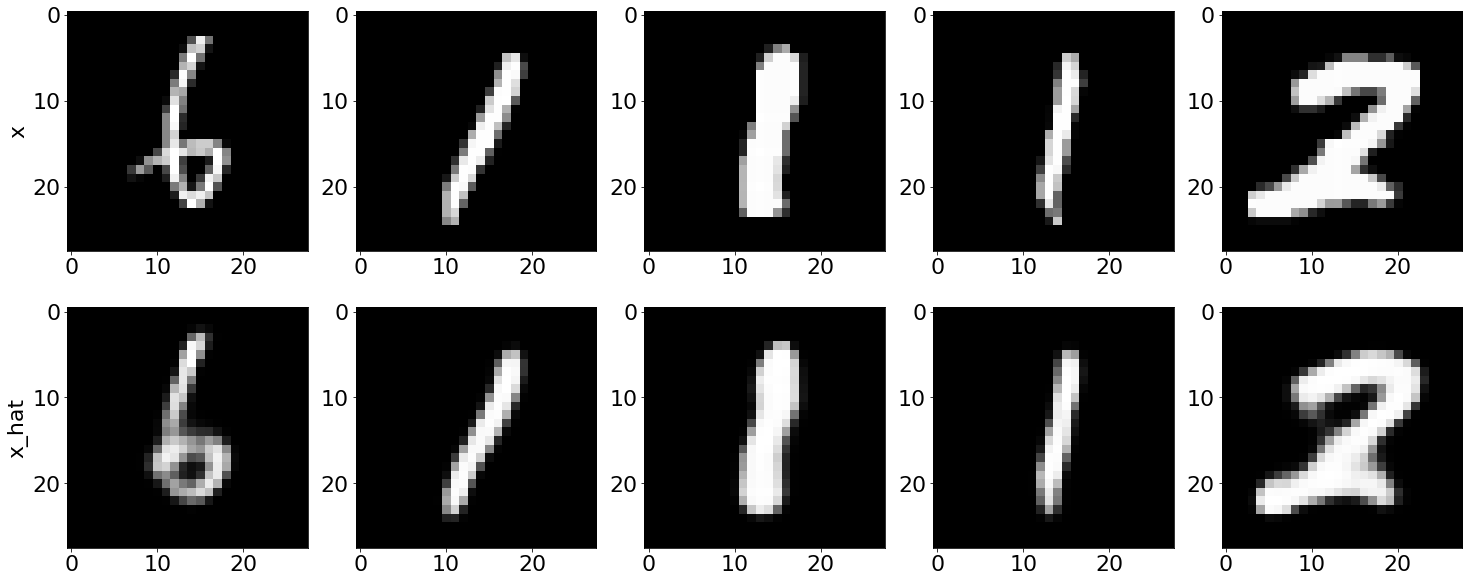

In [9]:
# Plot inputs and reconstructions.
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(2, NUM_SAMPLES, figsize=(25, 10))

for i in range(NUM_SAMPLES):
    ax[0][i].imshow(inputs[i], cmap='gray')
    ax[1][i].imshow(inputs_hat[i], cmap='gray')
    
text1 = ax[0][0].set_ylabel("x")
text2 = ax[1][0].set_ylabel("x_hat")        

### Counterfactual with Reinforcement Learning

In [10]:
# Define constants
COEFF_SPARSITY = 7.5               # sparisty coefficient
COEFF_CONSISTENCY = 0              # consisteny coefficient -> No consistency.
TRAIN_STEPS = 1000                 # number of training steps -> increase this to 150.000 or even further
BATCH_SIZE = 100                   # batch size

#### Define and fit the explainer

In [11]:
# Define explainer.
explainer = CounterfactualRLBase(predictor=predictor,
                                 encoder=ae.encoder,
                                 decoder=ae.decoder,
                                 latent_dim=LATENT_DIM,
                                 coeff_sparsity=COEFF_SPARSITY,
                                 coeff_consistency=COEFF_CONSISTENCY,
                                 train_steps=TRAIN_STEPS,
                                 batch_size=BATCH_SIZE,
                                 backend="tensorflow")

In [12]:
# Fit the explainer
explainer = explainer.fit(X=X_train)

100%|██████████| 1000/1000 [00:24<00:00, 40.55it/s]


#### Test explainer

In [13]:
# Generate counterfactuals for some test instances.
explanation = explainer.explain(X_test[0:200], Y_t=np.array([1]), batch_size=100)

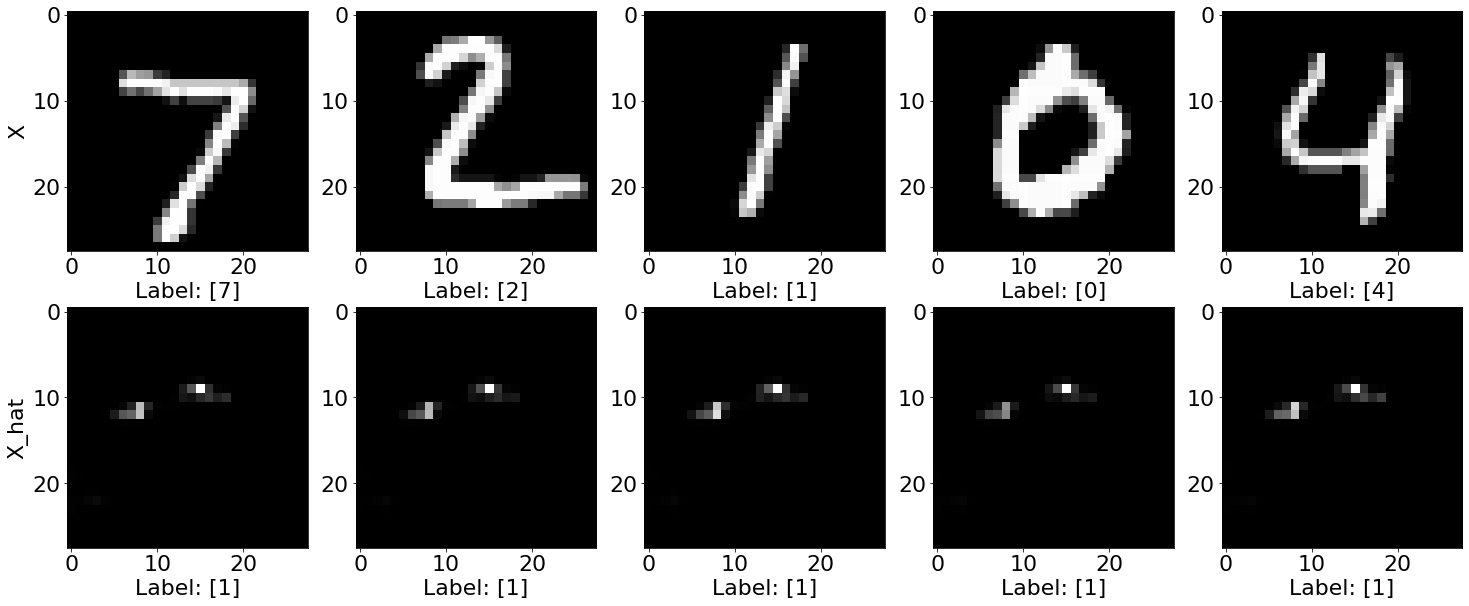

In [14]:
fig, ax = plt.subplots(2, NUM_SAMPLES, figsize=(25, 10))

for i in range(NUM_SAMPLES):
    ax[0][i].imshow(explanation.data['orig']['X'][i], cmap='gray')
    ax[1][i].imshow(explanation.data['cf']['X'][i], cmap='gray')
    
    ax[0][i].set_xlabel("Label: " + str(explanation.data['orig']['class'][i]))
    ax[1][i].set_xlabel("Label: " + str(explanation.data['cf']['class'][i]))
    

text1 = ax[0][0].set_ylabel("X")
text2 = ax[1][0].set_ylabel("X_hat")    

### Logging

Logging is clearly important when dealing with deep learning models. Thus, we provide two interfaces to write custom callbacks for logging purposes:

* an `ExperienceCallback`, called after each collected experience step;

```python
class ExperienceCallback:
    def __call__(self,
                 step: int,
                 model: CounterfactualRLBase,
                 sample: Dict[str, np.ndarray]) -> None:
        """
        Experience call-back applied after gather an experience.

        Parameters
        ----------
        step
            Current experience step.
        model
            CounterfactualRLBase explainer.
        sample
            Dictionary of sample gathered in an experience. This includes dataset inputs and intermediate
            results obtained during an experience.
        """
        pass
```

* a `TrainingCallback`, called after each training step;

```python
class TrainingCallback:
    def __call__(self,
                 step: int,
                 update: int,
                 model: CounterfactualRLBase,
                 sample: Dict[str, np.ndarray],
                 losses: Dict[str, float]) -> None:
        """
        Training call-back applied after every training step.

        Parameters
        -----------
        step
            Current experience step.
        update
            Current update. The ration between the number experience steps and the number of training 
            updates is bound to 1.
        model
            CounterfactualRLBase explainer.
        sample
            Dictionary of samples used for an update. This is sampled from the replay buffer.
        losses
            Dictionary of losses.
        """
        pass
```

In the following cells we provide some example to log in **Weights and Biases**.

#### Logging reward callback

In [15]:
class RewardCallback(ExperienceCallback):
    def __call__(self,
                 step: int, 
                 model: CounterfactualRLBase, 
                 sample: Dict[str, np.ndarray]):
        if step % 100 != 0:
            return
        
        # Get the counterfactual and target.
        X_cf = sample["X_cf"]
        Y_t = sample["Y_t"]
        
        # Get prediction label.
        Y_m_cf = predictor(X_cf)
        
        # Compute reward
        reward = np.mean(model.params["reward_func"](Y_m_cf, Y_t))
        wandb.log({"reward": reward})

#### Logging images callback

In [16]:
class ImagesCallback(ExperienceCallback):
    def __call__(self,
                 step:int,
                 model: CounterfactualRLBase,
                 sample: Dict[str, np.ndarray]):
        # Log every 100 steps
        if step % 100 != 0:
            return
        
        # Defie number of samples to be displayed.
        NUM_SAMPLES = 10
        
        X = sample["X"][:NUM_SAMPLES]        # input instance
        X_cf = sample["X_cf"][:NUM_SAMPLES]  # counterfactual
        diff = np.abs(X - X_cf)              # differences
        
        Y_m = sample["Y_m"][:NUM_SAMPLES].astype(int)   # input labels
        Y_t = sample["Y_t"][:NUM_SAMPLES].astype(int)   # target labels
        Y_m_cf = predictor(X_cf).astype(int)            # counterfactual labels
        
        # Concatentate images,
        X = np.concatenate(X, axis=1)
        X_cf = np.concatenate(X_cf, axis=1)
        diff = np.concatenate(diff, axis=1)
        
        # Construct full image.
        img = np.concatenate([X, X_cf, diff], axis=0)
            
        # Construct caption.
        caption = ""
        caption += "Input:\t%s\n" % str(list(np.argmax(Y_m, axis=1)))
        caption += "Target:\t%s\n" % str(list(np.argmax(Y_t, axis=1)))
        caption += "Predicted:\t%s\n" % str(list(np.argmax(Y_m_cf, axis=1)))
        
        # Log image.
        wandb.log({"samples": wandb.Image(img, caption=caption)})

#### Logging losses callback

In [17]:
class LossCallback(TrainingCallback):
    def __call__(self,
                 step: int, 
                 update: int, 
                 model: CounterfactualRLBase,
                 sample: Dict[str, np.ndarray],
                 losses: Dict[str, float]):
        # Log evary 100 updates.
        if (step + update) % 100 == 0:
            wandb.log(losses)

Having defined the callbacks, we can define a new explainer that will include logging.

In [18]:
# Define explainer.
explainer = CounterfactualRLBase(predictor=predictor,
                                 encoder=ae.encoder,
                                 decoder=ae.decoder,
                                 latent_dim=LATENT_DIM,
                                 coeff_sparsity=COEFF_SPARSITY,
                                 coeff_consistency=COEFF_CONSISTENCY,
                                 train_steps=TRAIN_STEPS,
                                 batch_size=BATCH_SIZE,
                                 experience_callbacks=[RewardCallback(), ImagesCallback()], # <--- here
                                 train_callbacks=[LossCallback()],                          # <--- here
                                 backend="tensorflow")

In [19]:
import wandb

# Initialize wandb.
wandb_project = "MNIST Counterfactual with Reinforcement Learning"
wandb.init(project=wandb_project)

# Fit the explainer.
explainer.fit(X=X_train)

# Close wandb.
wandb.finish()

wandb: Currently logged in as: rfs (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.11.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


100%|██████████| 1000/1000 [00:23<00:00, 41.80it/s]


reward,0.2
_runtime,27
_timestamp,1628266768
_step,28
loss_critic,0.02795
loss_actor,-0.09654
sparsity_loss,0.13068
consistency_loss,0


reward,▁▅▁▃▃▃▂▃▂█
_runtime,▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss_critic,▅▃▄▄▃▃▆█▁
loss_actor,▁▇██▇▇▇▇█
sparsity_loss,▆▁▂▃▆▆██▄
consistency_loss,▁▁▁▁▁▁▁▁▁
